In this script, we are processing the ARCOS data to get total mme per each transaction. We then add up total mme per month for each county. We merge the ARCOS data with census data to help account for population changes within each county over time. We then test each county via Chow test and adjust p-values to account for multiple tests. This script then outputs a csv file with county names and associated outcome variables, including direction of change, mean mme before and after, and percentage of change in mme.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import numpy as np

In [ ]:
#loading df
chunksize = 500000
data_chunks = []
for chunk in pd.read_csv('/content/drive/MyDrive/HED challenge/dataset w  filtered drugs, pharmacies, and mme conversion/mpanchbh_20241028222248.csv', chunksize=chunksize):
    data_chunks.append(chunk)
df = pd.concat(data_chunks, ignore_index=True)


In [ ]:
df.head()

,calc_base_wt_in_gm,transaction_date,buyer_county,buyer_bus_act,buyer_addl_co_info,drug_name,mme_conversion_factor
0,7.567500,01/01/2006,SAINT LAWRENCE,CHAIN PHARMACY,KINNEY DRUGS #09,HYDROCODONE,1.0
1,2.270250,01/01/2006,CAYUGA,CHAIN PHARMACY,KINNEY DRUGS #62,HYDROCODONE,1.0
2,0.572708,01/01/2006,SUFFOLK,RETAIL PHARMACY,NaN,HYDROCODONE,1.0
3,1.145417,01/01/2006,QUEENS,RETAIL PHARMACY,D/B/A CROSS BAY CHEMIST,HYDROCODONE,1.0
4,0.572708,01/01/2006,QUEENS,RETAIL PHARMACY,NaN,HYDROCODONE,1.0


Calculating total mme for each transaction

In [ ]:
df['total_mme'] = df['calc_base_wt_in_gm'] * 1000 * df['mme_conversion_factor']
df.head()

,calc_base_wt_in_gm,transaction_date,buyer_county,buyer_bus_act,buyer_addl_co_info,drug_name,mme_conversion_factor,total_mme
0,7.567500,01/01/2006,SAINT LAWRENCE,CHAIN PHARMACY,KINNEY DRUGS #09,HYDROCODONE,1.0,7567.5000
1,2.270250,01/01/2006,CAYUGA,CHAIN PHARMACY,KINNEY DRUGS #62,HYDROCODONE,1.0,2270.2500
2,0.572708,01/01/2006,SUFFOLK,RETAIL PHARMACY,NaN,HYDROCODONE,1.0,572.7084
3,1.145417,01/01/2006,QUEENS,RETAIL PHARMACY,D/B/A CROSS BAY CHEMIST,HYDROCODONE,1.0,1145.4169
4,0.572708,01/01/2006,QUEENS,RETAIL PHARMACY,NaN,HYDROCODONE,1.0,572.7084


In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%m/%d/%Y')
df['year'] = df['transaction_date'].dt.year
df['month'] = df['transaction_date'].dt.month
df.head()

,calc_base_wt_in_gm,transaction_date,buyer_county,buyer_bus_act,buyer_addl_co_info,drug_name,mme_conversion_factor,total_mme,year,month
0,7.567500,2006-01-01,SAINT LAWRENCE,CHAIN PHARMACY,KINNEY DRUGS #09,HYDROCODONE,1.0,7567.5000,2006,1
1,2.270250,2006-01-01,CAYUGA,CHAIN PHARMACY,KINNEY DRUGS #62,HYDROCODONE,1.0,2270.2500,2006,1
2,0.572708,2006-01-01,SUFFOLK,RETAIL PHARMACY,NaN,HYDROCODONE,1.0,572.7084,2006,1
3,1.145417,2006-01-01,QUEENS,RETAIL PHARMACY,D/B/A CROSS BAY CHEMIST,HYDROCODONE,1.0,1145.4169,2006,1
4,0.572708,2006-01-01,QUEENS,RETAIL PHARMACY,NaN,HYDROCODONE,1.0,572.7084,2006,1


In [ ]:
monthly_mme = df.groupby(['buyer_county', 'year', 'month'])['total_mme'].sum().reset_index()
monthly_mme.head()

,buyer_county,year,month,total_mme
0,ALBANY,2006,1,7.518827e+06
1,ALBANY,2006,2,6.010821e+06
2,ALBANY,2006,3,8.658889e+06
3,ALBANY,2006,4,6.308959e+06
4,ALBANY,2006,5,5.227228e+06


Merging population data with total mme data

In [ ]:
county_pop = pd.read_csv("/content/drive/MyDrive/HED challenge/dataset w  filtered drugs, pharmacies, and mme conversion/ny county pop estimates + fips.csv")
county_pop['County Name'] = county_pop['County Name'].str.upper()
county_pop.columns = county_pop.columns.str.strip()
year_cols = [col for col in county_pop.columns if col.isdigit()]  # Extract year columns
county_pop[year_cols] = county_pop[year_cols].replace(',', '', regex=True).astype(int)
county_pop_long = county_pop.melt(id_vars=['FIPS', 'County Name'],
                                  var_name='year',
                                  value_name='population')
county_pop_long['year'] = county_pop_long['year'].astype(int)
print(county_pop_long.head())


   FIPS     County Name  year  population
0    36  NEW YORK STATE  2006      303997
1     1          ALBANY  2006       49359
2     3        ALLEGANY  2006     1348164
3     5           BRONX  2006      200905
4     7          BROOME  2006       81342


In [ ]:
merged_data = pd.merge(monthly_mme, county_pop_long, left_on=['buyer_county', 'year'],
                       right_on=['County Name', 'year'], how='left')
print(merged_data.head())

  buyer_county  year  month     total_mme  FIPS County Name  population
0       ALBANY  2006      1  7.518827e+06   1.0      ALBANY     49359.0
1       ALBANY  2006      2  6.010821e+06   1.0      ALBANY     49359.0
2       ALBANY  2006      3  8.658889e+06   1.0      ALBANY     49359.0
3       ALBANY  2006      4  6.308959e+06   1.0      ALBANY     49359.0
4       ALBANY  2006      5  5.227228e+06   1.0      ALBANY     49359.0


Diving total mme by population for each county

In [ ]:
merged_data = merged_data.dropna(subset=['total_mme', 'population'])
merged_data['mme/pop'] = merged_data['total_mme'].astype(float) / merged_data['population'].astype(float)
merged_data.head()

<ipython-input-25-2bcdcc230baa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['mme/pop'] = merged_data['total_mme'].astype(float) / merged_data['population'].astype(float)


,buyer_county,year,month,total_mme,FIPS,County Name,population,mme/pop
0,ALBANY,2006,1,7.518827e+06,1.0,ALBANY,49359.0,152.329399
1,ALBANY,2006,2,6.010821e+06,1.0,ALBANY,49359.0,121.777606
2,ALBANY,2006,3,8.658889e+06,1.0,ALBANY,49359.0,175.426741
3,ALBANY,2006,4,6.308959e+06,1.0,ALBANY,49359.0,127.817809
4,ALBANY,2006,5,5.227228e+06,1.0,ALBANY,49359.0,105.902227


<Figure size 1200x600 with 0 Axes>

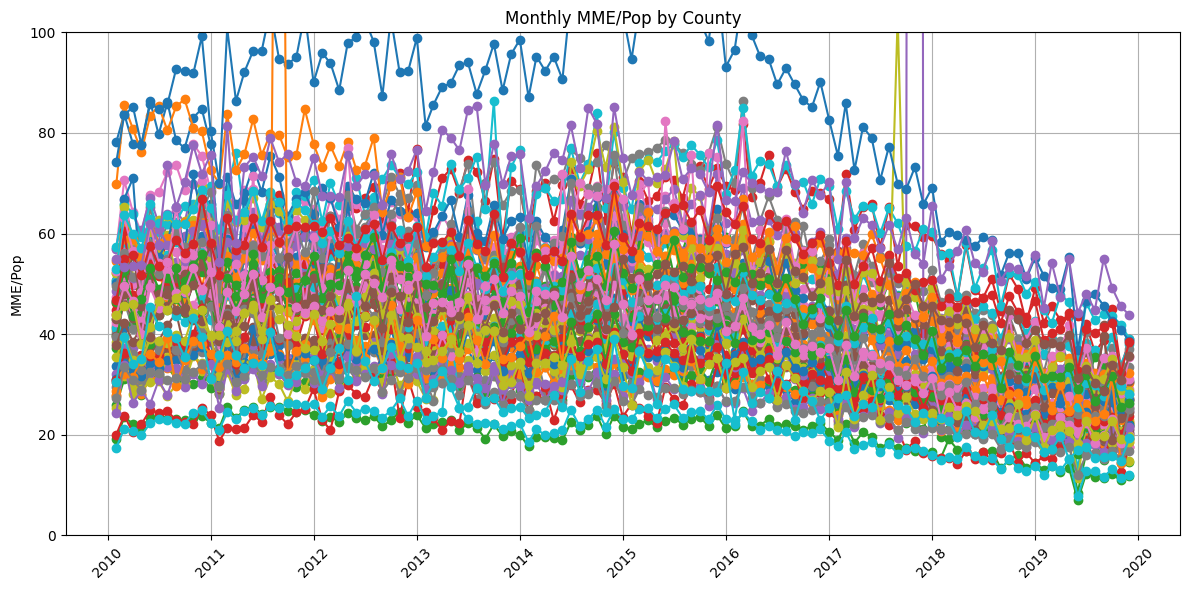

In [ ]:
plt.figure(figsize=(12, 6))
#merged_data['date'] = pd.to_datetime(merged_data[['year', 'month']].assign(day=1))
filtered_data = merged_data[merged_data['date'] > '2010-01-01']
plt.figure(figsize=(12, 6))

for county, group in filtered_data.groupby('buyer_county'):
    plt.plot(group['date'], group['mme/pop'], marker='o', label=county)

plt.title('Monthly MME/Pop by County')
plt.ylabel('MME/Pop')

plt.xticks(rotation=45)
plt.ylim(0,100)
plt.grid()
plt.tight_layout()

plt.show()

Defining chow test

In [ ]:
def chow_test(data, breakpoint, y_col, year_col, month_col):
    data['date'] = pd.to_datetime(data[year_col].astype(str) + '-' + data[month_col].astype(str))

    data_before = data[data['date'] < breakpoint]
    data_after = data[data['date'] >= breakpoint]

    if len(data_before) == 0 or len(data_after) == 0:
        return np.nan, np.nan


    X_before = sm.add_constant(data_before[month_col])
    model_before = sm.OLS(data_before[y_col], X_before).fit()
    ssr1 = sum(model_before.resid ** 2)

    X_after = sm.add_constant(data_after[month_col])
    model_after = sm.OLS(data_after[y_col], X_after).fit()
    ssr2 = sum(model_after.resid ** 2)


    X_combined = sm.add_constant(data[month_col])
    model_combined = sm.OLS(data[y_col], X_combined).fit()
    ssr_c = sum(model_combined.resid ** 2)


    N1 = len(data_before)
    N2 = len(data_after)
    k = len(model_combined.params)
    F = ((ssr_c - (ssr1 + ssr2)) / k) / ((ssr1 + ssr2) / (N1 + N2 - 2 * k))


    p_value = stats.f.sf(F, k, N1 + N2 - 2 * k)


    coeff_before = model_before.params[1]
    coeff_after = model_after.params[1]
    direction = "increased" if coeff_after > coeff_before else "decreased"

    return p_value, direction

Applying chow test to each county in database

In [ ]:
breakpoint = pd.Timestamp('2013-08-01')
results = []


for county, group in merged_data.groupby('buyer_county'):

    if len(group) < 10:
        continue

    p_value, direction = chow_test(group, breakpoint, 'mme/pop', 'year', 'month')

    if p_value is not np.nan:
        results.append({
            'County Name': county,
            'p-value': p_value,
            'Trend Direction': direction
        })

results_df = pd.DataFrame(results)

print(results_df.head())

<ipython-input-34-f281987a02d3>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_before = model_before.params[1]  # Slope for the month variable before the breakpoint
<ipython-input-34-f281987a02d3>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_after = model_after.params[1]    # Slope for the month variable after the breakpoint
<ipython-input-34-f281987a02d3>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_b

   County Name       p-value Trend Direction
0       ALBANY  7.870616e-17       decreased
1     ALLEGANY  1.656640e-05       increased
2        BRONX  4.619302e-16       decreased
3       BROOME  8.432767e-12       decreased
4  CATTARAUGUS  4.287734e-01       increased


<ipython-input-34-f281987a02d3>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_before = model_before.params[1]  # Slope for the month variable before the breakpoint
<ipython-input-34-f281987a02d3>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_after = model_after.params[1]    # Slope for the month variable after the breakpoint
<ipython-input-34-f281987a02d3>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_b

In [ ]:
!pip install statsmodels

Adjusting p-values to account for multiple hypothesis testing

In [ ]:
#apply Hommel's method for p-value adjustment
from statsmodels.stats.multitest import multipletests
results_df['adjusted_p_value'] = multipletests(results_df['p-value'], method='hommel')[1]
results_df['significance'] = ['s' if adj_p < 0.05 else 'ns' for adj_p in results_df['adjusted_p_value']]

print(results_df)


    County Name       p-value Trend Direction  adjusted_p_value significance
0        ALBANY  7.870616e-17       decreased      3.541777e-15            s
1      ALLEGANY  1.656640e-05       increased      2.650624e-04            s
2         BRONX  4.619302e-16       decreased      1.847721e-14            s
3        BROOME  8.432767e-12       decreased      2.529830e-10            s
4   CATTARAUGUS  4.287734e-01       increased      7.952099e-01           ns
5        CAYUGA  1.365410e-03       decreased      1.501951e-02            s
6    CHAUTAUQUA  2.017723e-26       decreased      1.129925e-24            s
7       CHEMUNG  2.114658e-06       decreased      4.229316e-05            s
8      CHENANGO  6.688884e-07       decreased      1.471555e-05            s
9       CLINTON  2.219103e-14       decreased      7.544950e-13            s
10     COLUMBIA  4.859821e-15       decreased      1.749536e-13            s
11     CORTLAND  4.166886e-07       decreased      9.583837e-06            s

In [ ]:
county_trend = results_df
county_trend.loc[county_trend['significance'] == 'ns', 'Trend Direction'] = 'neutral'

final_trend_direction = results_df[['County Name', 'Trend Direction']]
final_trend_direction.head()

,County Name,Trend Direction
0,ALBANY,decreased
1,ALLEGANY,increased
2,BRONX,decreased
3,BROOME,decreased
4,CATTARAUGUS,neutral


In [ ]:
final_trend_direction.to_csv('/content/drive/MyDrive/HED challenge/dataset w  filtered drugs, pharmacies, and mme conversion/county_trend_directions.csv')

Adding quantitative measures of change alongside a binary outcome variable

In [ ]:
#creating a quantitative measure of change in mme/pop before and after august 2013, overall dataset
merged_data['period'] = merged_data.apply(
    lambda row: 'before' if (row['year'] < 2013) or (row['year'] == 2013 and row['month'] < 8) else 'after',
    axis=1
)

mean_mme_pop = merged_data.groupby('period')['mme/pop'].mean().reset_index()

mean_before = mean_mme_pop.loc[mean_mme_pop['period'] == 'before', 'mme/pop'].values[0]
mean_after = mean_mme_pop.loc[mean_mme_pop['period'] == 'after', 'mme/pop'].values[0]

absolute_change = mean_after - mean_before

percentage_change = (absolute_change / mean_before) * 100 if mean_before != 0 else None

summary_df = pd.DataFrame({
    'Mean MME/Pop Before': [mean_before],
    'Mean MME/Pop After': [mean_after],
    'Absolute Change': [absolute_change],
    'Percentage Change': [percentage_change]
})

print(summary_df)

   Mean MME/Pop Before  Mean MME/Pop After  Absolute Change  Percentage Change
0           101.564682           39.967166       -61.597515         -60.648559


In [ ]:
mean_mme_pop = merged_data.groupby(['buyer_county', 'period'])['mme/pop'].mean().reset_index()

mean_mme_pop_pivot = mean_mme_pop.pivot(index='buyer_county', columns='period', values='mme/pop').reset_index()

mean_mme_pop_pivot['Absolute Change'] = mean_mme_pop_pivot['after'] - mean_mme_pop_pivot['before']
mean_mme_pop_pivot['Percentage Change'] = (
    (mean_mme_pop_pivot['Absolute Change'] / mean_mme_pop_pivot['before']) * 100
    ).where(mean_mme_pop_pivot['before'] != 0)

mean_mme_pop_pivot.columns.name = None
mean_mme_pop_pivot = mean_mme_pop_pivot.rename(columns={'before': 'Mean MME/Pop Before', 'after': 'Mean MME/Pop After'})

print(mean_mme_pop_pivot)

   buyer_county  Mean MME/Pop After  Mean MME/Pop Before  Absolute Change  \
0        ALBANY           28.023322           115.593487       -87.570165   
1      ALLEGANY           35.998743            22.785193        13.213550   
2         BRONX           25.757088           101.304826       -75.547738   
3        BROOME           61.004665            86.934795       -25.930130   
4   CATTARAUGUS           43.504494            66.984211       -23.479718   
5        CAYUGA           32.132188            26.807411         5.324777   
6    CHAUTAUQUA           48.377047            73.256982       -24.879935   
7       CHEMUNG           58.360779            69.467637       -11.106858   
8      CHENANGO           31.256799            25.561496         5.695303   
9       CLINTON           49.449049            57.792712        -8.343663   
10     COLUMBIA           40.087218            48.824329        -8.737111   
11     CORTLAND           38.508645            45.454236        -6.945591   

In [ ]:
direction_and_percentages = pd.merge(final_trend_direction, mean_mme_pop_pivot,
                        left_on='County Name', right_on='buyer_county',
                        how='inner')
direction_and_percentages.drop(columns='buyer_county', inplace=True)
direction_and_percentages.head()

,County Name,Trend Direction,Mean MME/Pop After,Mean MME/Pop Before,Absolute Change,Percentage Change
0,ALBANY,decreased,28.023322,115.593487,-87.570165,-75.757006
1,ALLEGANY,increased,35.998743,22.785193,13.213550,57.991828
2,BRONX,decreased,25.757088,101.304826,-75.547738,-74.574668
3,BROOME,decreased,61.004665,86.934795,-25.930130,-29.827102
4,CATTARAUGUS,neutral,43.504494,66.984211,-23.479718,-35.052615


In [ ]:
direction_and_percentages.to_csv('/content/drive/MyDrive/HED challenge/dataset w  filtered drugs, pharmacies, and mme conversion/county_directions_percentchanges.csv')